# Deep Learning - Melanoma Tumor Detection




## Introduction

### Why do we need this study?


**Deep Learning** has emerged as a powerful tool in the field of **medical imaging** and has shown great potential in aiding the health community in the detection and diagnosis of **melanoma**. By leveraging deep learning algorithms, we can analyze medical images, such as **dermoscopy** or **biopsies**, with unprecedented accuracy and efficiency. Also, it can assist in the classification of melanoma into different subtypes. By training models on large datasets of labeled melanoma images, deep learning algorithms can learn to distinguish between various types of melanoma, such as basal cell melanoma, squamous cell melanoma, or malignant melanoma.

Overall, deep learning has the potential to revolutionize melanoma detection and diagnosis. By leveraging the power of neural networks, we can enhance the accuracy, efficiency, and understanding of melanoma imaging, ultimately leading to improved patient care and outcomes in the field of dermatologic oncology.

### Problem Statement

The accurate detection and classification of **melanoma** play a crucial role in the diagnosis and treatment planning of patients. However, manual interpretation of medical images, such as dermoscopic scans, can be time-consuming and subjective, leading to potential errors and delays in patient care. Therefore, there is a need for an automated and reliable method to detect and classify melanoma from medical images.

### Study Aim

This study aims to develop a Convolutional Neural Network **(CNN)** using the **Keras** framework that can accurately detect and classify **Melanoma Tumors** from many curated images where every pixel holds the potential to redefine early detection. The CNN will be trained on a large dataset (13900 images) to learn the patterns and features associated with different skin types and also the views of melanoma's diverse manifestations.The study aims develop reliable models with high accuracy for melanoma classification.

## Project Enviroment and Dataset Setup

### Preparing the enviroment using Google Colab GPU
</div>

<h2> NOTE: Skip this if running locally! </h2>

As train enviroment we decide to move forward using the Google Colab GPU (free version) once the power of computational using GPUs is very efficient became the training process more fast (200x) than locally train. With this configuration we can train and also test many hipermarameters to increse the model performance.

To be able to get access to Google Colab GPUs we needed:

1. Change the RunTime at the top menu setting: 'Runtime -> Change Runtime Type --> under the Hardware Accelerator
2. Download the repository to config the GPUs for ML
3. Install the python lib colab

In [1]:
#!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
#!python rapidsai-csp-utils/colab/pip-install.py

### Function to extracting the Dataset
</div>

This script sets up a project directory and extracts a dataset from the kaggle file and the extract_archive function extracts files from the archive zip into the dataset folder.

Additionally, the script moves a portion of the files from the training set to the validation set to create a validation dataset. This ensures that the model's performance can be properly evaluated during training.

The setup_project function encapsulates all these functionalities and sets up the project directory accordingly.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time
#!pip install tqdm
#!pip install zipfile

import os
from zipfile import ZipFile
from tqdm import tqdm
from random import sample as rnd_sample
from shutil import move as move_file

def setup_project():
    print("Setting up project!!!")
    dir_files = os.listdir()

    #this extracts from archive zip the dataset
    def extract_archive():
        with ZipFile("./archive.zip", 'r') as zip_obj:
            file_list = zip_obj.namelist()
            with tqdm(total=len(file_list), desc="Extracting files") as pbar:
                for file in file_list:
                    zip_obj.extract(file, path="./dataset/")
                    pbar.update(1)

    if "dataset" not in dir_files:
        print("dataset folder not in project, creating it...")
        os.mkdir('dataset')

    if "archive.zip" not in dir_files:
        raise Exception("archive.zip IS NOT IN PROJECT, CANNOT SETUP IT UP")

    dataset_files = os.listdir("./dataset")

    if len(dataset_files) < 2:
        print("Extracting archive.zip!!!")
        extract_archive()

    def move_files_to_validation():
        paths = ['./dataset/train/Benign', './dataset/train/Malignant']
        for path in paths:
            prefix = path.split('/')[-1]
            files = os.listdir('./dataset/train/' + prefix)
            n_files = int(len(files) * 0.2)
            for file in tqdm(rnd_sample(files, n_files), desc=f"Moving files to validation for {prefix}"):
                move_file(f"./dataset/train/{prefix}/{file}", f"./dataset/validation/{prefix}/{file}")

    if "validation" not in dataset_files:
        print("Creating validation folder...")
        os.mkdir('./dataset/validation')
        print("Creating validation/Benign folder...")
        os.mkdir('./dataset/validation/Benign')
        print("Creating validation/Malignant folder...")
        os.mkdir('./dataset/validation/Malignant')
        move_files_to_validation()

setup_project()

Setting up project!!!
CPU times: total: 0 ns
Wall time: 12.5 ms


### Data preprocessing
</div>

Here we rescale the images with the rescale parameter set to 1/255, we normalize the pixel values of our images to fall within the range [0, 1], a common preprocessing step that aids in model convergence and stability.

In [3]:
%%time
#!pip install tensorflow

train_dir = "./dataset/train/"
validation_dir = "./dataset/validation"
test_dir = "./dataset/test/"
target_size = (240, 240)
batch_size = 20

CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
%%time
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = target_size,
    batch_size = batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = target_size,
    batch_size = batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 9504 images belonging to 2 classes.
Found 2375 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
CPU times: total: 547 ms
Wall time: 1.05 s


The script displays the number of images found in each directory belonging to their respective classes: 9504 images for training and 2375 images for validation, divided in 2 classes, this being malignant and benign.

## Exploratory Data Analysis

### Class images samples

In [5]:
assert train_generator.class_indices == validation_generator.class_indices

class_to_index_map = train_generator.class_indices
index_to_class_map = dict((v, k) for k, v in train_generator.class_indices.items())
print("class_to_index_map ->", class_to_index_map)
print("index_to_class_map ->", index_to_class_map)

class_to_index_map -> {'Benign': 0, 'Malignant': 1}
index_to_class_map -> {0: 'Benign', 1: 'Malignant'}


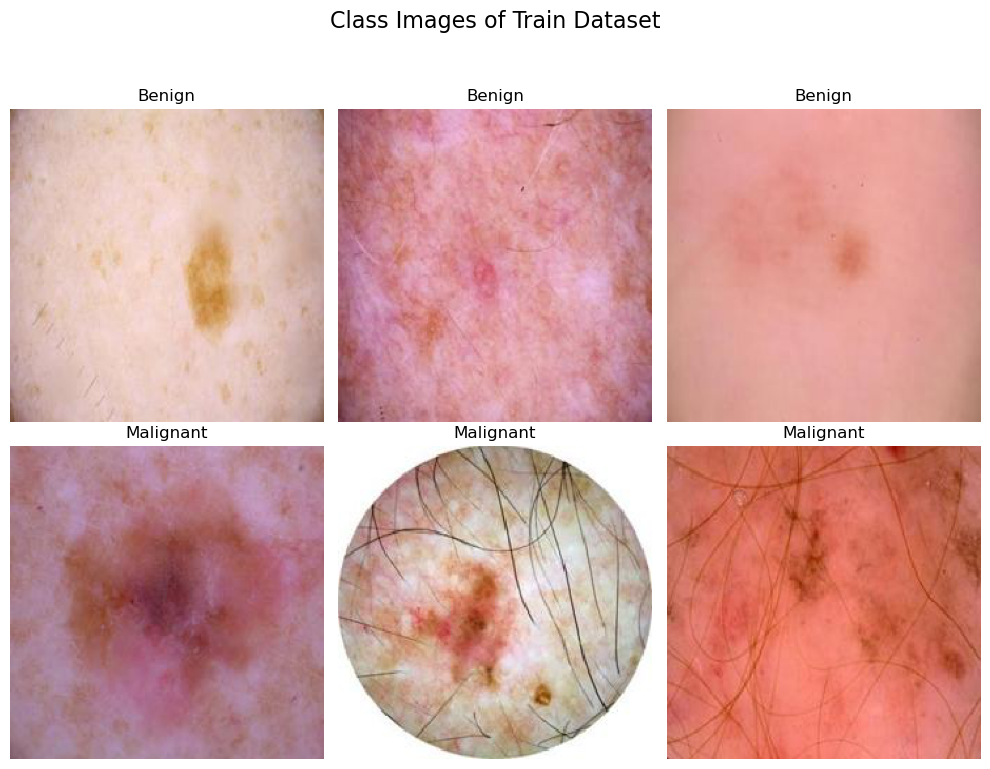

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define the dictionary to store the images by class name
images_per_class = {'Benign': [], 'Malignant': []}

# Quantity of images per class
desired_count_per_class = 3

# Loop until the both class got the same number of images
while any(len(images) < desired_count_per_class for images in images_per_class.values()):
    imagens, labels = next(train_generator)
    for i, label in enumerate(labels):
        class_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(label)]
        if len(images_per_class[class_name]) < desired_count_per_class:
            images_per_class[class_name].append(imagens[i])

# Plotting images
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
fig.suptitle('Class Images of Train Dataset', fontsize=16)

for row, class_name in enumerate(images_per_class.keys()):
    for col in range(desired_count_per_class):
        axes[row, col].imshow(images_per_class[class_name][col])
        axes[row, col].set_title(class_name)
        axes[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


### Division by Class in Train set

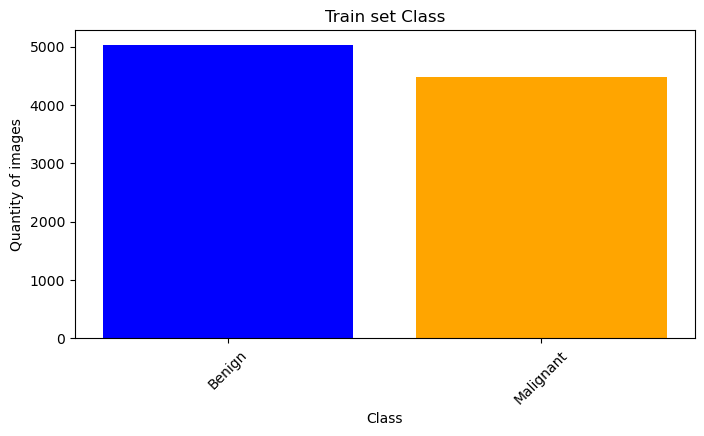

In [7]:
import os
import matplotlib.pyplot as plt

# Finding the local of the train folders for each class
train_dirs = {class_name: os.path.join(train_dir, class_name) for class_name in train_generator.class_indices.keys()}

# Count the files for each class
image_counts = {class_name: len(os.listdir(path)) for class_name, path in train_dirs.items()}

# Class name and quantities
class_names = list(image_counts.keys())
counts = list(image_counts.values())

# Plotting bar graph
plt.figure(figsize=(8, 4))
plt.bar(class_names, counts, color=['blue', 'orange'])

plt.title('Train set Class')
plt.xlabel('Class')
plt.ylabel('Quantity of images')
plt.xticks(rotation=45)
plt.show()

##  Model building & fitting | Classifier

The initial model building was the benchmark of deep learning slides classes, we decide to use the "standard" model to check the behavior of the the neural network with this kind of images.

### Set The Initial parameters
</div>

We also implement to the epoch_steps and Validation_steps the math operation to find the ideal number for this paramters

In [9]:
%%time
# Define some paramenters for the model
import math

input_shape = (240, 240, 3)
epochs = 30
epoch_steps = int(math.ceil(train_generator.samples/batch_size - batch_size))
validation_steps = int(math.ceil(validation_generator.samples/batch_size - batch_size))
print(f"Epoch steps -> {epoch_steps} | Validation steps -> {validation_steps}")

Epoch steps -> 456 | Validation steps -> 99
CPU times: total: 0 ns
Wall time: 0 ns


### Building The CNN Model
</div>

The first approch with this model was to create one non complex model to optmize the computational resource and check the behaviour of the model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Example of building a neural netword
classifier = Sequential()

# Pooling and Convuluted layers
classifier.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a flattening layer to flatten our data
classifier.add(Flatten())

# Dense Layers
classifier.add(Dense(128, activation='relu'))
classifier.add(Dense(1, activation='sigmoid'))

classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 238, 238, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 119, 119, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 117, 117, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 215296)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    27,558,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,577,537 (105.20 MB)

 Trainable params: 27,577,537 (105.20 MB)

 Non-trainable params: 0 (0.00 B)

### Config the Compile

In [11]:
%%time
# Model Compilation
classifier.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

CPU times: total: 0 ns
Wall time: 12.1 ms


### Setup the GPU (If it is avaliable) 
</div>

Since the training can be a bit slow, we can speed it up by allocation a part of the computation to the GPU instead of just CPU: https://samanemami.medium.com/how-to-enhance-training-speed-in-tensorflow-72d950f041bb

In [12]:
# Get the GPU memory fraction to allocate
gpu_memory_fraction = 0.8

# Create GPUOptions with the fraction of GPU memory to allocate
gpu_options = tf.compat.v1.GPUOptions(
    per_process_gpu_memory_fraction=gpu_memory_fraction
)

# Create a session with the GPUOptions
session = tf.compat.v1.Session(
    config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)
)

### Trainning The CNN Model

In [13]:
%%time
history = classifier.fit(
    train_generator,
    steps_per_epoch = epoch_steps,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps
)

Epoch 1/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 274s 597ms/step - accuracy: 0.6964 - loss: 0.7829 - val_accuracy: 0.7889 - val_loss: 0.4302
Epoch 2/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.7959 - loss: 0.4260 - val_accuracy: 0.7797 - val_loss: 0.4542
Epoch 3/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 266s 582ms/step - accuracy: 0.8076 - loss: 0.4158 - val_accuracy: 0.7904 - val_loss: 0.4478
Epoch 4/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.8047 - loss: 0.3977 - val_accuracy: 0.8076 - val_loss: 0.4161
Epoch 5/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 271s 594ms/step - accuracy: 0.8292 - loss: 0.3639 - val_accuracy: 0.8384 - val_loss: 0.3657
Epoch 6/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.7927 - loss: 0.4128 - val_accuracy: 0.7722 - val_loss: 0.4726
Epoch 7/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 273s 598ms/step - accuracy: 0.8507 - loss: 0.3372 - val_accuracy: 0.8394 - val_loss: 0.3491
Epoch 8/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.8569 - loss: 0

### Model validation

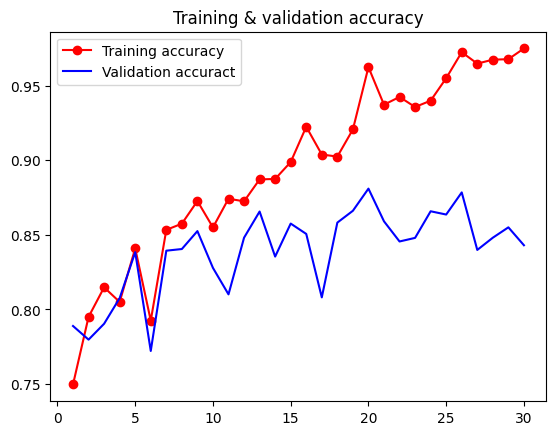

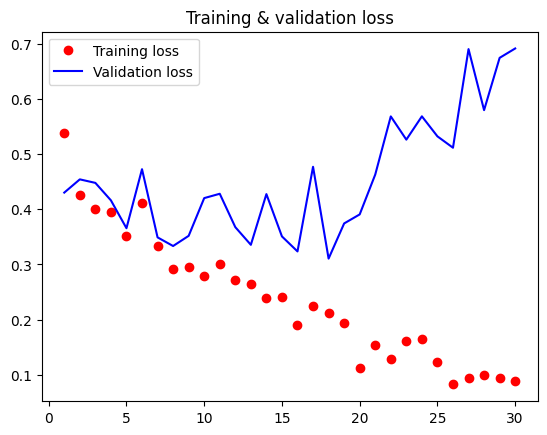

CPU times: total: 78.1 ms
Wall time: 346 ms


In [14]:
%%time
import matplotlib.pyplot as plt

def plot_accuracy_loss_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo-', color='red', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuract')
    plt.title('Training & validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', color='red', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training & validation loss')
    plt.legend()

    plt.show()

plot_accuracy_loss_graph(history)

### Accuracy | Results</b></p>
</div>

**Training Accuracy (red)**: The training accuracy starts around 0.7 and quickly rises, stabilizing around 0.9. This indicates that the model is learning and adjusting well to the training data.

**Validation Accuracy (blue)**: The validation accuracy begins well below the training accuracy, which is normal in the initial training cycles, but it increases and reaches a level similar to the training after a few epochs.
It appears to oscillate slightly, but remains relatively stable, which is a good sign that the model is generalizing well and not merely memorizing the training data.

### Loss | Results</b></p>
</div>

**Training Loss (red)**: The training loss starts high, peaking in the early stages, but quickly decreases and stabilizes close to zero, indicating that the model is getting better at predicting the correct labels in the training set.

**Validation Loss (blue)**: The validation loss also starts high with a peak in the beginning and then decreases. However, unlike the accuracy, the validation loss seems to exhibit more variability and fluctuations. This may be a sign that the model is struggling to adapt to the validation data as well as the training data, although the overall trend of decreasing loss is maintained.

### Overall Results Analysis</b></p>
</div>

**Overfitting**: The model does not appear to suffer from significant overfitting, as the validation and training accuracy are quite close and the validation losses do not increase over time.

**Stability**: The model appears stable, as after the initial peak in the early epochs, the metrics tend to stabilize.

**Initial Peaks**: The peaks in the training and validation loss in the first epoch are notable. This may be due to a poorly chosen initial set of weights, an initially too high learning rate, or simply the model quickly adjusting to the data.

**Variations in Accuracy and Validation Loss**: The fluctuations in accuracy and validation loss suggest that the model may benefit from adjustments to the learning rate or the use of regularization methods, such as dropout or weight regularization, to help smooth out these fluctuations.

##  Improvements and Adjustments previous Model | Classifier2</b>

Based in the first results from the initial model, we decided to implement the dropout in order to smooth out the small overfitting after 20 epochs, the main goal is the stability.

The droupout will be setted in 0.5

We also implement the callback to ensure the best version of the model, and setup it monitoring the accuracy with 5 patience iterations

In [15]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Define callbacks
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = "accuracy",
        patience = 5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = "improved_model.keras",
        monitor = "val_loss",
        save_best_only = True,
    )
]


# Example of building a neural netword
classifier2 = Sequential()

# Pooling and Convuluted layers
classifier2.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
classifier2.add(MaxPooling2D(pool_size=(2, 2)))
classifier2.add(Conv2D(64, (3, 3), activation='relu'))
classifier2.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a flattening layer to flatten our data
classifier2.add(Flatten())

# Dense Layers and adding dropout
classifier2.add(Dense(128, activation='relu'))
classifier2.add(Dropout(0.5))
classifier2.add(Dense(1, activation='sigmoid'))

classifier2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 238, 238, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 119, 119, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 117, 117, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 215296)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    27,558,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,577,537 (105.20 MB)

 Trainable params: 27,577,537 (105.20 MB)

 Non-trainable params: 0 (0.00 B)

### Config the Compile

In [16]:
# Model Compilation
classifier2.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

### Trainning The CNN Model improved | Classifier2

In [17]:
%%time
history2 = classifier2.fit(
    train_generator,
    steps_per_epoch = epoch_steps,
    epochs = epochs,
    callbacks = callbacks_list,
    validation_data = validation_generator,
    validation_steps = validation_steps
)

Epoch 1/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 261s 568ms/step - accuracy: 0.6956 - loss: 0.9697 - val_accuracy: 0.7894 - val_loss: 0.4456
Epoch 2/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.8264 - loss: 0.3902 - val_accuracy: 0.7975 - val_loss: 0.4035
Epoch 3/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 261s 572ms/step - accuracy: 0.8215 - loss: 0.4082 - val_accuracy: 0.7843 - val_loss: 0.4515
Epoch 4/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.8351 - loss: 0.3462 - val_accuracy: 0.8228 - val_loss: 0.3901
Epoch 5/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 312s 683ms/step - accuracy: 0.8376 - loss: 0.3824 - val_accuracy: 0.8470 - val_loss: 0.3518
Epoch 6/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.8558 - loss: 0.3120 - val_accuracy: 0.8633 - val_loss: 0.3570
Epoch 7/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 257s 562ms/step - accuracy: 0.8429 - loss: 0.3640 - val_accuracy: 0.8399 - val_loss: 0.3686
Epoch 8/30
456/456 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.8691 - loss: 0

### Model validation | Classifier2

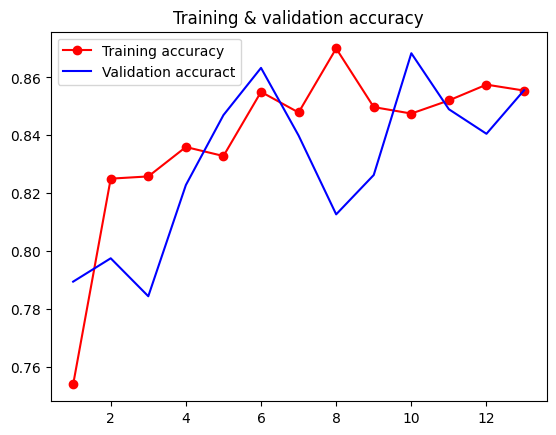

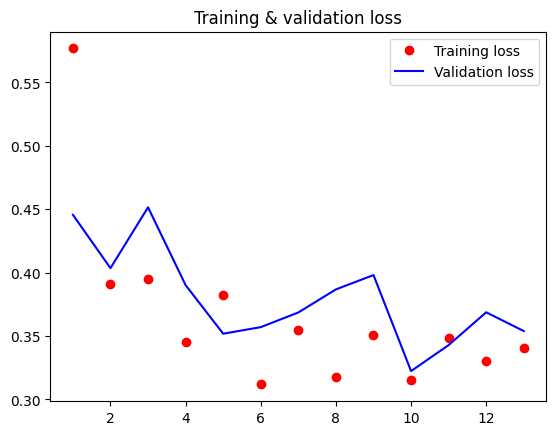

CPU times: total: 62.5 ms
Wall time: 364 ms


In [18]:
%%time
import matplotlib.pyplot as plt

def plot_accuracy_loss_graph(history2):
    acc = history2.history['accuracy']
    val_acc = history2.history['val_accuracy']
    loss = history2.history['loss']
    val_loss = history2.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo-', color='red', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuract')
    plt.title('Training & validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', color='red', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training & validation loss')
    plt.legend()

    plt.show()

plot_accuracy_loss_graph(history2)

As we can see, there's been a huge improvement resulting in a non-overfitting model that can actually be used.

##  Model testing

With the model validated and improved, we can now fully test it against our test dataset and get a realistic measure of accuracy:

In [19]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np

best_model = load_model("improved_model.keras")

#basically our preprocess flow right now...
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0  # rescale pixel values to [0,1]

We'll also shuffle the test files:

In [20]:
from random import shuffle

benign_test_files = ['./dataset/test/Benign/' + f for f in os.listdir('./dataset/test/Benign/')]
malignant_test_files = ['./dataset/test/Malignant/' + f for f in os.listdir('./dataset/test/Malignant/')]
all_test_files = benign_test_files + malignant_test_files
shuffle(all_test_files)
all_test_files

['./dataset/test/Malignant/6137.jpg',
 './dataset/test/Malignant/5970.jpg',
 './dataset/test/Benign/7012.jpg',
 './dataset/test/Malignant/6346.jpg',
 './dataset/test/Benign/6337.jpg',
 './dataset/test/Benign/6680.jpg',
 './dataset/test/Malignant/6000.jpg',
 './dataset/test/Benign/6564.jpg',
 './dataset/test/Malignant/5873.jpg',
 './dataset/test/Malignant/5999.jpg',
 './dataset/test/Benign/7249.jpg',
 './dataset/test/Benign/6429.jpg',
 './dataset/test/Benign/7137.jpg',
 './dataset/test/Malignant/6143.jpg',
 './dataset/test/Benign/6455.jpg',
 './dataset/test/Malignant/5932.jpg',
 './dataset/test/Benign/7234.jpg',
 './dataset/test/Malignant/5659.jpg',
 './dataset/test/Benign/6879.jpg',
 './dataset/test/Malignant/6568.jpg',
 './dataset/test/Malignant/5783.jpg',
 './dataset/test/Benign/7297.jpg',
 './dataset/test/Benign/7170.jpg',
 './dataset/test/Benign/6390.jpg',
 './dataset/test/Benign/6522.jpg',
 './dataset/test/Benign/7147.jpg',
 './dataset/test/Benign/7195.jpg',
 './dataset/test/Benig

Predicting images is now relatively easy and be achieved with the code below:

In [21]:
#simple method for predicting for test image
def predict_image(image_path):
    #preproccess it
    image_array = preprocess_image(image_path)
    result = best_model.predict(image_array, verbose = 0).flatten()
    #has to be single result...
    if result.shape[0] != 1:
        raise Exception(f'Error in predicting {image_path}')
    #base result is probability of being positive case...
    certainty = result[0]
    #parse it through a threshold
    predicted_class = 1 if certainty > 0.5 else 0
    #retrieve associated label
    predicted_class_label = index_to_class_map[predicted_class]
    #return all this info...
    return (certainty, predicted_class, predicted_class_label)

An example follows:

In [22]:
print("Testing file", all_test_files[3])
if all_test_files[3].split('/')[-2] == predict_image(all_test_files[3])[2]:
    print(f"Correctly predicted image as {all_test_files[3].split('/')[-2]}")
else:
    print(f"Incorrectly predicted image, did not predict as {all_test_files[3].split('/')[-2]}")

Testing file ./dataset/test/Malignant/6346.jpg
Correctly predicted image as Malignant


We can see that it correctly predicted, the class. We now apply the same principle to the rest of the images:

In [23]:
correct_predictions = sum(predict_image(test_file)[2] == test_file.split('/')[-2] for test_file in tqdm(all_test_files, desc="Predicting test files"))
accuracy_rate = (correct_predictions / len(all_test_files)) * 100
print(f"Real accuracy rate: {accuracy_rate:.2f}%")

Predicting test files: 100%|██████████| 2000/2000 [02:45<00:00, 12.09it/s]

Real accuracy rate: 87.45%


As we can see, we have very near validation results, of more than 80% accuracy! So our model is definitely appropriate for this task!